In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
#importing libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [72]:
df = pd.read_csv('Data/rice production across different countries from 1961 to 2021.csv')
df.head()

,Area,Year,Unit,Value,Flag,Flag Description
0,Afghanistan,1961,tonnes,319000.0,A,Official figure
1,Afghanistan,1962,tonnes,319000.0,A,Official figure
2,Afghanistan,1963,tonnes,319000.0,A,Official figure
3,Afghanistan,1964,tonnes,380000.0,A,Official figure
4,Afghanistan,1965,tonnes,380000.0,A,Official figure


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7324 entries, 0 to 7323
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              7324 non-null   object 
 1   Year              7324 non-null   int64  
 2   Unit              7324 non-null   object 
 3   Value             7324 non-null   float64
 4   Flag              7324 non-null   object 
 5   Flag Description  7324 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 343.4+ KB


In [5]:
df.isnull().sum()

Area                0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [4]:
type(df['Year'][0])

numpy.int64

In [9]:
dates = pd.to_datetime(
                        df['Year'].astype(str)
                       )
dates

0      1961-01-01
1      1962-01-01
2      1963-01-01
3      1964-01-01
4      1965-01-01
          ...    
7319   2017-01-01
7320   2018-01-01
7321   2019-01-01
7322   2020-01-01
7323   2021-01-01
Name: Year, Length: 7324, dtype: datetime64[ns]

In [7]:
type(dates[0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
new = pd.DataFrame()
new['ds'] = dates
new['y'] = df['Value']
new

,ds,y
0,1961-01-01,319000.00
1,1962-01-01,319000.00
2,1963-01-01,319000.00
3,1964-01-01,380000.00
4,1965-01-01,380000.00
...,...,...
7319,2017-01-01,1326.90
7320,2018-01-01,1342.47
7321,2019-01-01,1134.00
7322,2020-01-01,750.00


In [25]:
# Set year column as index
new.set_index('ds', inplace=True)

# Resample to annual frequency
new = new.resample('A').mean()
new

,y
ds,
1961-12-31,2.494167e+06
1962-12-31,2.680106e+06
1963-12-31,2.968427e+06
1964-12-31,3.170752e+06
1965-12-31,3.134230e+06
...,...
2017-12-31,7.663097e+06
2018-12-31,6.771557e+06
2019-12-31,6.699247e+06


In [28]:
new['ds']=new.index
new

,y,ds
ds,,
1961-12-31,2.494167e+06,1961-12-31
1962-12-31,2.680106e+06,1962-12-31
1963-12-31,2.968427e+06,1963-12-31
1964-12-31,3.170752e+06,1964-12-31
1965-12-31,3.134230e+06,1965-12-31
...,...,...
2017-12-31,7.663097e+06,2017-12-31
2018-12-31,6.771557e+06,2018-12-31
2019-12-31,6.699247e+06,2019-12-31


In [18]:
for i in df.drop(columns=['Value']).columns:
    print('Unique values of',i,':',len(list(df[i].unique())))

Unique values of Area : 149
Unique values of Year : 61
Unique values of Unit : 1
Unique values of Flag : 5
Unique values of Flag Description : 5


(array([657., 674., 678., 674., 681., 742., 756., 755., 753., 954.]),
 array([1961., 1967., 1973., 1979., 1985., 1991., 1997., 2003., 2009.,
        2015., 2021.]),
 <BarContainer object of 10 artists>)

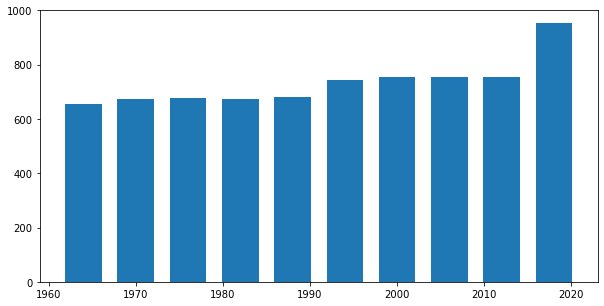

In [22]:
plt.figure(figsize=(10,5))
plt.hist(df['Year'],rwidth = 0.7)

# Data Analysis

In [2]:
train_dates=pd.to_datetime(df.Year.astype('str'),dayfirst=True)
train_dates

0      1961-01-01
1      1962-01-01
2      1963-01-01
3      1964-01-01
4      1965-01-01
          ...    
7319   2017-01-01
7320   2018-01-01
7321   2019-01-01
7322   2020-01-01
7323   2021-01-01
Name: Year, Length: 7324, dtype: datetime64[ns]

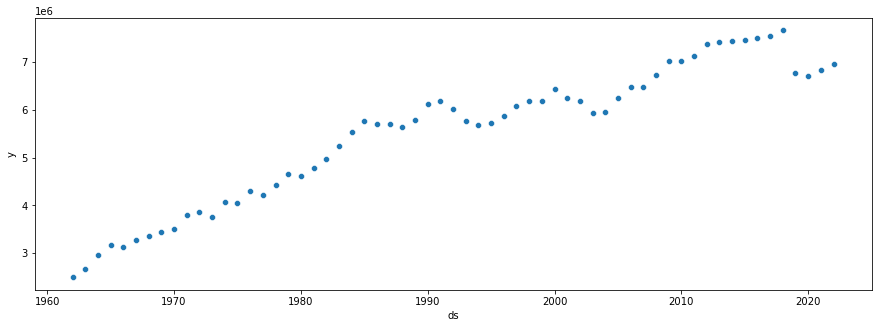

In [29]:
plt.figure(figsize=(15,5))
sns.scatterplot(new['ds'],new['y'])
plt.show()

In [33]:
df.sort_values('Value')

,Area,Year,Unit,Value,Flag,Flag Description
4660,Netherlands,2018,tonnes,0.0,A,Official figure
2721,Germany,2018,tonnes,0.0,A,Official figure
330,Armenia,2021,tonnes,0.0,M,"Missing value (data cannot exist, not applicable)"
329,Armenia,2020,tonnes,0.0,M,"Missing value (data cannot exist, not applicable)"
328,Armenia,2019,tonnes,0.0,M,"Missing value (data cannot exist, not applicable)"
...,...,...,...,...,...,...
1400,China,2020,tonnes,213610729.1,E,Estimated value
1395,China,2015,tonnes,213723732.1,E,Estimated value
1398,China,2018,tonnes,214078796.1,E,Estimated value
1401,China,2021,tonnes,214403870.1,E,Estimated value


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


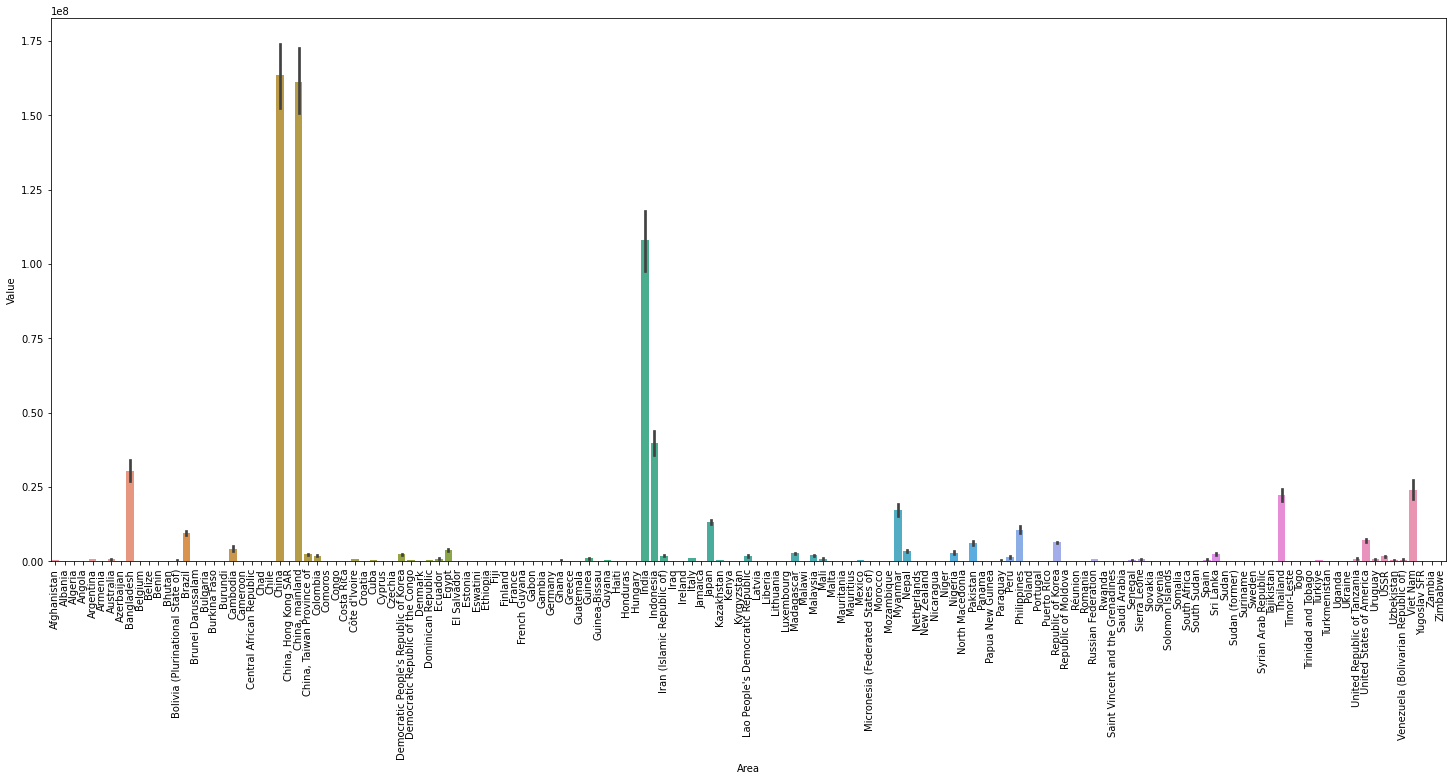

In [36]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
sns.barplot(df.Area,df.Value)
plt.show()

In [37]:
import tensorflow as tf

In [38]:
tf.__version__

'2.12.0-dev20221224'

In [39]:
import keras

In [40]:
keras.__version__

'2.12.0'

# LSTM

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
df = pd.read_csv('Data/rice production across different countries from 1961 to 2021.csv')

In [19]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
df.Value = scalar.fit_transform(df.Value.values.reshape(-1,1))

In [6]:
#Lists for storing the training data considering multiple variables
#trainX for storing training data (temperature,wind speed,relative humidity)
#trainY for storing target values(rainfall)
trainX=[] 
trainY=[]

n_past=30 #30 values will be considered to predict the next values
n_fut=80#for predicting the next 80 value based on previous 30 values

#Adding the values to trainX and trainY lists
for i in range(n_past,len(training_df_scaled)-n_fut+1):
    trainX.append(training_df_scaled[i-n_past:i,0:training_df_scaled.shape[1]])
    trainY.append(training_df_scaled[i+n_fut-1:i+n_fut,0])

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

#Converting into numpy arrays
trainX,trainY=np.array(train.Year.values.reshape(-1,1)),np.array(train.Value.values.reshape(-1,1))

print('trainX shape == {}'.format(trainX.shape))#Knowing the shape 
#(364,20,4) means there are 364windows(groups) of 20*4


print('trainY shape == {}'.format(trainY.shape))
#There are 364 values from previous values

trainX shape == (5859, 1)
trainY shape == (5859, 1)


In [14]:
model=Sequential()
model.add(LSTM(32,activation='relu',input_shape=(1,1),return_sequences=True))
model.add(Dropout(0.3))

'''model.add(layers.BatchNormalization())

model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.3))'''

model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse',metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_4 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras import backend as K
jobs = 6 # it means number of cores
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.compat.v1.Session(config=config)
K.set_session(session)

In [20]:
history=model.fit(trainX,trainY,epochs=10,batch_size=5,validation_split=0.2,verbose=1)

Epoch 1/10
938/938 [==============================] - 3s 4ms/step - loss: 947037805740032.0000 - accuracy: 4.2671e-04 - val_loss: 10950440648704.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
938/938 [==============================] - 3s 4ms/step - loss: 943045432311808.0000 - accuracy: 4.2671e-04 - val_loss: 10722428846080.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 942555134951424.0000 - accuracy: 4.2671e-04 - val_loss: 10570373791744.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 940577705164800.0000 - accuracy: 4.2671e-04 - val_loss: 10480645046272.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 939697035542528.0000 - accuracy: 4.2671e-04 - val_loss: 10464144654336.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 938579068977152.0000 - accuracy: 4.2671e-

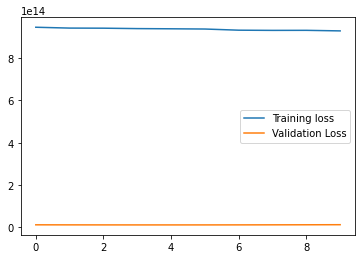

In [21]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [22]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
train_dates=pd.to_datetime(df.Year,dayfirst=True)

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 30
n_days_for_prediction=80

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

# make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 1 variables for transform, the inverse expects same dimensions
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)

y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Value':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

3/3 [==============================] - 1s 3ms/step


In [42]:
prediction = model.predict(test.Year.values.reshape(-1,1))

46/46 [==============================] - 0s 2ms/step


In [43]:
prediction.reshape(1,-1)[0]

array([6516816.5, 6520044.5, 6523272.5, ..., 6520044.5, 6523272.5,
       6526500. ], dtype=float32)

In [44]:
df_forecast = pd.DataFrame({'Date':np.array(test.Year), 'Value':prediction.reshape(1,-1)[0]})
df_forecast['Date']=df_forecast['Date']

In [41]:
trainX[-n_days_for_prediction:].shape
#(100, 30, 1) 30days

(100, 30, 1)

In [37]:
scalar.transform(df_forecast.Value.values.reshape(-1,1)).shape

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(100, 1)

In [23]:
test

,Area,Year,Unit,Value,Flag,Flag Description
5859,Slovenia,2018,tonnes,0.00,A,Official figure
5860,Slovenia,2019,tonnes,0.00,A,Official figure
5861,Slovenia,2020,tonnes,0.00,A,Official figure
5862,Slovenia,2021,tonnes,0.00,A,Official figure
5863,Solomon Islands,1961,tonnes,200.00,E,Estimated value
...,...,...,...,...,...,...
7319,Zimbabwe,2017,tonnes,1326.90,I,Imputed value
7320,Zimbabwe,2018,tonnes,1342.47,I,Imputed value
7321,Zimbabwe,2019,tonnes,1134.00,A,Official figure
7322,Zimbabwe,2020,tonnes,750.00,E,Estimated value


# ARIMA

In [43]:
# Split data into training and testing sets
train_size = int(len(new) * 0.8)
train, test = new['y'].iloc[:train_size], new['y'].iloc[train_size:]
print(train.shape)
print(test.shape)

(48,)
(13,)


In [57]:
# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Make predictions on testing set
predictions = model_fit.forecast(len(test))

MAE: 330445.62
R2_score: -1.513144909407135


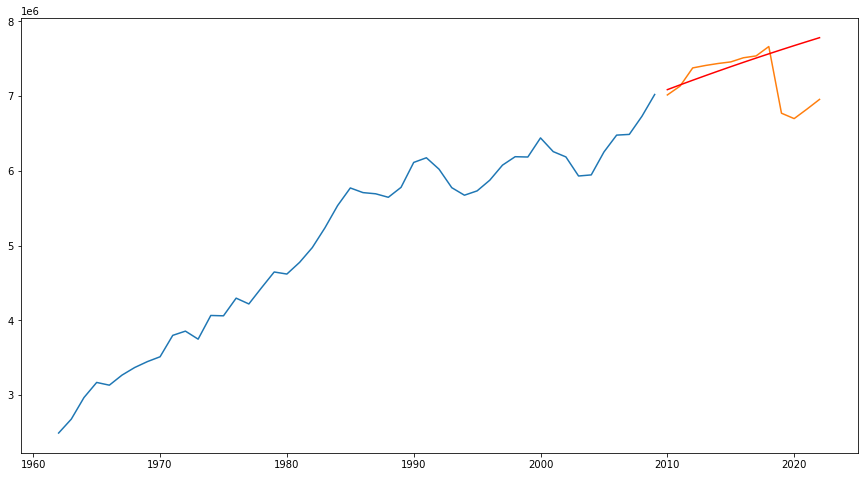

In [58]:
# RMSE
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
print('MAE: %.2f' % mae)
print('R2_score:',r2)

# Plot predictions and actual values
plt.figure(figsize=(15,8))
plt.plot(train)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


In [65]:
# Define parameter grid for grid search
import itertools
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))


# Perform grid search
best_score, best_cfg, bestfit = float('inf'), None, None
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        y_pred = model_fit.forecast(len(test))
        mae = mean_absolute_error(test, y_pred)
        print(param,'MAE:',mae)
        if mae < best_score:
            best_score, best_cfg, bestfit = mae, param, model_fit
    except:
        continue

print('Best parameters: ', best_cfg)
print('mae: ', best_score)

(0, 0, 0) MAE: 2163087.232055017
(0, 0, 1) MAE: 2100035.1076148124
(0, 0, 2) MAE: 2021346.93052962
(0, 1, 0) MAE: 322645.88805441407
(0, 1, 1) MAE: 315522.6448755602
(0, 1, 2) MAE: 298630.6470499881
(0, 2, 0) MAE: 1843446.313675422
(0, 2, 1) MAE: 1743915.450572959
(0, 2, 2) MAE: 1391022.4672651344
(1, 0, 0) MAE: 324808.8920515854
(1, 0, 1) MAE: 305660.1996564325
(1, 0, 2) MAE: 276469.594741488
(1, 1, 0) MAE: 311127.17853949714
(1, 1, 1) MAE: 330445.6211766582
(1, 1, 2) MAE: 337513.9535196569
(1, 2, 0) MAE: 1804730.6464688745
(1, 2, 1) MAE: 921166.7149428566
(1, 2, 2) MAE: 966840.6144948067
(2, 0, 0) MAE: 270624.3946361325
(2, 0, 1) MAE: 247923.91791565673
(2, 0, 2) MAE: 268203.8357253258
(2, 1, 0) MAE: 292498.41366963426
(2, 1, 1) MAE: 340786.37379511015
(2, 1, 2) MAE: 331444.3021476872
(2, 2, 0) MAE: 1697161.5455664385
(2, 2, 1) MAE: 968089.2103020253
(2, 2, 2) MAE: 931586.2182603148
Best parameters:  (2, 0, 1)
mae:  247923.91791565673


mae: 247923.92


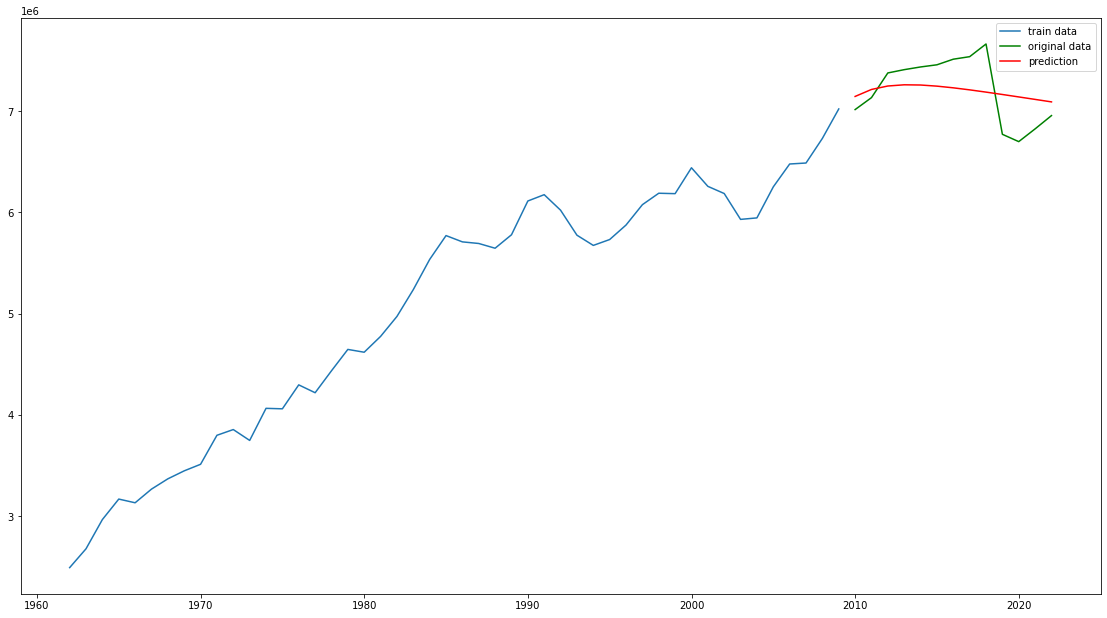

In [66]:
# Make predictions on testing set
# parameters (2,0,1)
predictions = bestfit.forecast(steps=len(test))

# Mean absolute error calculation
mae = mean_absolute_error(test, predictions)
print('mae: %.2f' % mae)

# Plot predictions and actual values
fig=plt.figure(figsize=(15,8))
ax = fig.add_axes([1, 1, 1, 1])
ax=plt.plot(train,label='train data')
ax=plt.plot(test,color='green',label='original data')
ax=plt.plot(predictions, color='red',label='prediction')
plt.legend()
plt.show()

# LSTM

In [27]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('Data/rice production across different countries from 1961 to 2021.csv')

# Convert year column to datetime index
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
df

,Area,Unit,Value,Flag,Flag Description
Year,,,,,
1961-01-01,Afghanistan,tonnes,319000.00,A,Official figure
1962-01-01,Afghanistan,tonnes,319000.00,A,Official figure
1963-01-01,Afghanistan,tonnes,319000.00,A,Official figure
1964-01-01,Afghanistan,tonnes,380000.00,A,Official figure
1965-01-01,Afghanistan,tonnes,380000.00,A,Official figure
...,...,...,...,...,...
2017-01-01,Zimbabwe,tonnes,1326.90,I,Imputed value
2018-01-01,Zimbabwe,tonnes,1342.47,I,Imputed value
2019-01-01,Zimbabwe,tonnes,1134.00,A,Official figure


In [28]:
# Define window size for LSTM model
window_size = 3

df = df[['Value']]
# Create lagged versions of the data to use as features
X = []
y = []
for i in range(window_size, len(df)):
    X.append(df.iloc[i-window_size:i, 0])
    y.append(df.iloc[i, 0])
X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Reshape data for LSTM model
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [32]:
train_size = int(len(X) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

# Train LSTM model
model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
183/183 - 4s - loss: 769136166699008.0000 - accuracy: 0.0372 - 4s/epoch - 21ms/step
Epoch 2/10
183/183 - 0s - loss: 769136368025600.0000 - accuracy: 0.0073 - 499ms/epoch - 3ms/step
Epoch 3/10
183/183 - 1s - loss: 769136435134464.0000 - accuracy: 3.4153e-04 - 503ms/epoch - 3ms/step
Epoch 4/10
183/183 - 1s - loss: 769136166699008.0000 - accuracy: 3.4153e-04 - 509ms/epoch - 3ms/step
Epoch 5/10
183/183 - 1s - loss: 769135965372416.0000 - accuracy: 3.4153e-04 - 513ms/epoch - 3ms/step
Epoch 6/10
183/183 - 0s - loss: 769136099590144.0000 - accuracy: 3.4153e-04 - 481ms/epoch - 3ms/step
Epoch 7/10
183/183 - 1s - loss: 769135562719232.0000 - accuracy: 3.4153e-04 - 505ms/epoch - 3ms/step
Epoch 8/10
183/183 - 0s - loss: 769135764045824.0000 - accuracy: 3.4153e-04 - 490ms/epoch - 3ms/step
Epoch 9/10
183/183 - 1s - loss: 769135495610368.0000 - accuracy: 3.4153e-04 - 506ms/epoch - 3ms/step
Epoch 10/10
183/183 - 0s - loss: 769135495610368.0000 - accuracy: 3.4153e-04 - 491ms/epoch - 3ms/step

In [31]:
from sklearn.metrics import mean_squared_error

# Generate predictions on test data
y_pred = model.predict(test_X)

# Calculate root mean squared error
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print('RMSE:', rmse)


46/46 [==============================] - 1s 2ms/step
RMSE: 7567646.125705667


In [56]:
train_X.shape

(5856, 3, 1)

In [66]:
test_X.shape

(1465, 3, 1)

In [65]:
y_pred.shape

(1465, 1)

46/46 [==============================] - 0s 2ms/step


ValueError: x and y must have same first dimension, but have shapes (1465,) and (1462, 1)

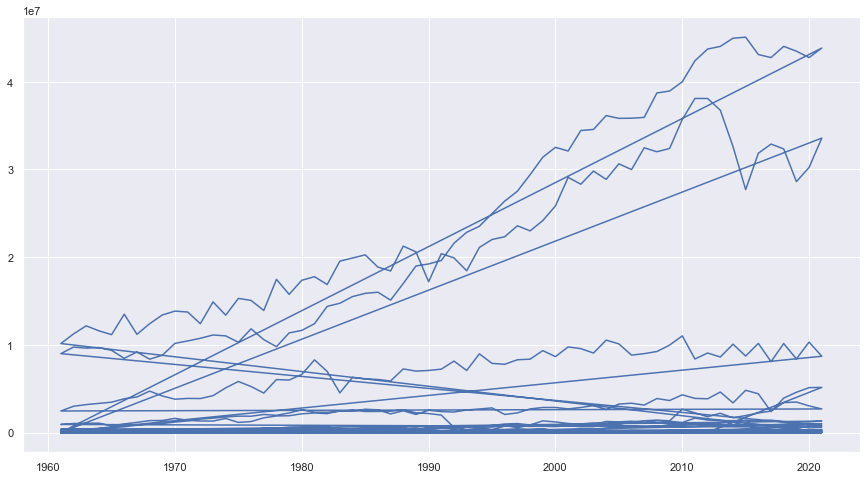

In [35]:
import matplotlib.pyplot as plt

# Generate predictions on test data
test_pred = model.predict(test_X)

# Plot actual vs predicted values for test data
plt.plot(test.index[window_size:], test['Value'][window_size:], label='Actual')
plt.plot(test.index[window_size:], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [40]:
test.sort_index()

,Value
Year,
1961-01-01,229500.0
1961-01-01,923024.0
1961-01-01,8997400.0
1961-01-01,19000.0
1961-01-01,1931.0
...,...
2021-01-01,0.0
2021-01-01,0.0
2021-01-01,263749.0


In [44]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
t1 = test
t1.Value = scale.fit_transform(t1.Value.values.reshape(-1,1))

C:\Users\ashwi\AppData\Local\Temp\ipykernel_23140\3148760216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1.Value = scale.fit_transform(t1.Value.values.reshape(-1,1))


In [45]:
t1.sort_index()

,Value
Year,
1961-01-01,-0.320907
1961-01-01,-0.223620
1961-01-01,0.909056
1961-01-01,-0.350436
1961-01-01,-0.352831
...,...
2021-01-01,-0.353102
2021-01-01,-0.353102
2021-01-01,-0.316103


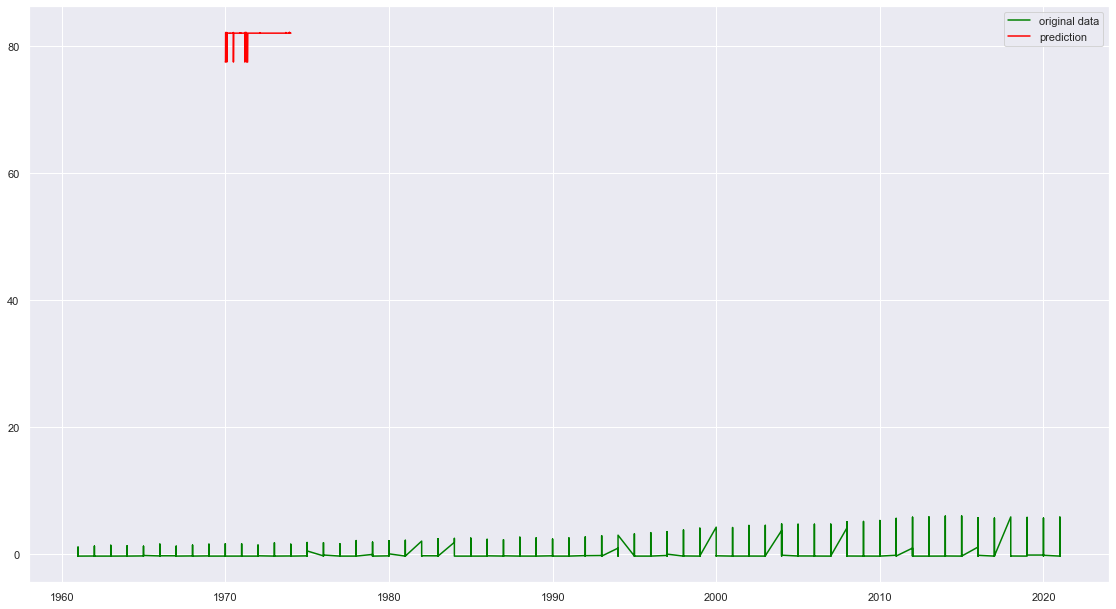

In [46]:
# Plot predictions and actual values
import matplotlib.pyplot as plt


figs=plt.figure(figsize=(15,8))
ax1 = figs.add_axes([1, 1, 1, 1])
#ax1=plt.plot(train,label='train data')
ax1=plt.plot(t1.sort_index(),color='green',label='original data')
ax1=plt.plot(y_pred, color='red',label='prediction')
plt.legend()
plt.show()

In [49]:
df = df.resample('A').mean()
df

,Value
Year,
1961-12-31,2.494167e+06
1962-12-31,2.680106e+06
1963-12-31,2.968427e+06
1964-12-31,3.170752e+06
1965-12-31,3.134230e+06
...,...
2017-12-31,7.663097e+06
2018-12-31,6.771557e+06
2019-12-31,6.699247e+06


# SARIMA

In [50]:
#importing libraries
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [74]:
# Ad fulller test
ad_fuller_result = adfuller(new['y'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.285195040875315
p-value: 0.176787332251283


In [52]:
# Hyperparamter optimisation
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [53]:
# Number of parameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [54]:
# Hyper Parameter Optimisation
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, df['Value'])
result_df
#find param with least AIC

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 3, 1)",22.000000
1,"(0, 0, 2, 1)",1543.466373
2,"(0, 0, 1, 1)",1543.484752
3,"(0, 0, 3, 0)",1544.000003
4,"(0, 0, 2, 2)",1544.713248
...,...,...
251,"(3, 3, 3, 3)",1558.690224
252,"(1, 3, 3, 3)",1558.705779
253,"(0, 3, 0, 0)",1558.817442
254,"(3, 2, 3, 3)",1559.101148


In [75]:
# Fitting the model
best_model = SARIMAX(new['y']).fit(dis=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -835.998
Date:                Fri, 07 Apr 2023   AIC                           1675.997
Time:                        15:33:54   BIC                           1680.219
Sample:                    12-31-1961   HQIC                          1677.651
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.002    598.499      0.000       0.996       1.003
sigma2      3.867e+10   1.53e-16   2.52e+26      0.000    3.87e+10    3.87e+10
Ljung-Box (L1) (Q):                   1.34   Jarque-

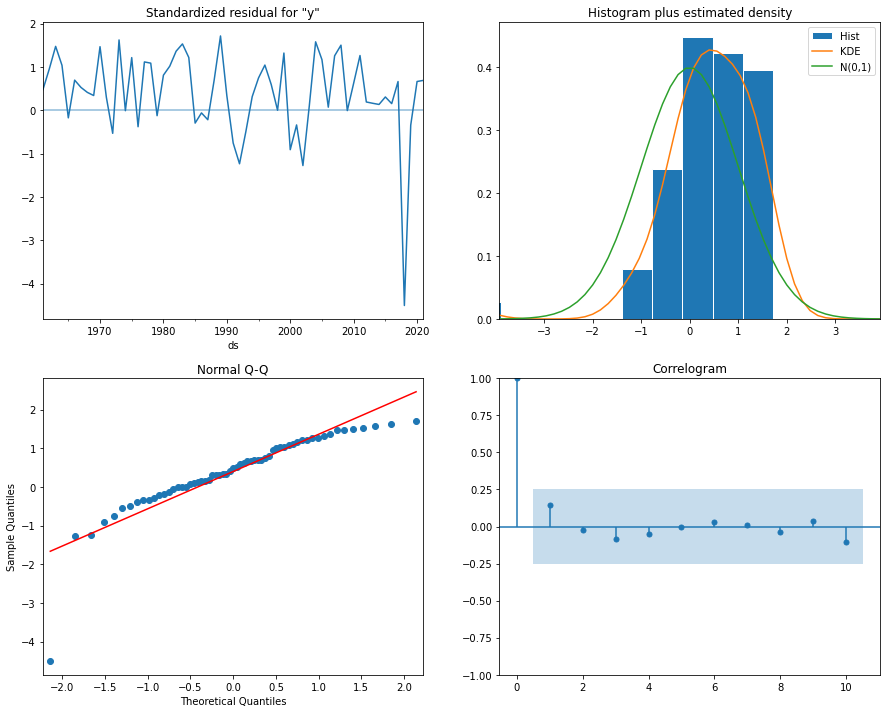

In [76]:
# Model Diagnostics
best_model.plot_diagnostics(figsize=(15,12));

In [79]:
new

,y,ds,arima_model
ds,,,
1961-12-31,2.494167e+06,1961-12-31,NaN
1962-12-31,2.680106e+06,1962-12-31,NaN
1963-12-31,2.968427e+06,1963-12-31,NaN
1964-12-31,3.170752e+06,1964-12-31,NaN
1965-12-31,3.134230e+06,1965-12-31,NaN
...,...,...,...
2017-12-31,7.663097e+06,2017-12-31,7.532504e+06
2018-12-31,6.771557e+06,2018-12-31,7.657646e+06
2019-12-31,6.699247e+06,2019-12-31,6.766741e+06


In [85]:
#df['Year']=pd.to_datetime(df['Year'].astype('str'))
new

,y,ds,arima_model
ds,,,
1961-12-31,2.494167e+06,1961-12-31,NaN
1962-12-31,2.680106e+06,1962-12-31,NaN
1963-12-31,2.968427e+06,1963-12-31,NaN
1964-12-31,3.170752e+06,1964-12-31,NaN
1965-12-31,3.134230e+06,1965-12-31,NaN
...,...,...,...
2017-12-31,7.663097e+06,2017-12-31,7.532504e+06
2018-12-31,6.771557e+06,2018-12-31,7.657646e+06
2019-12-31,6.699247e+06,2019-12-31,6.766741e+06


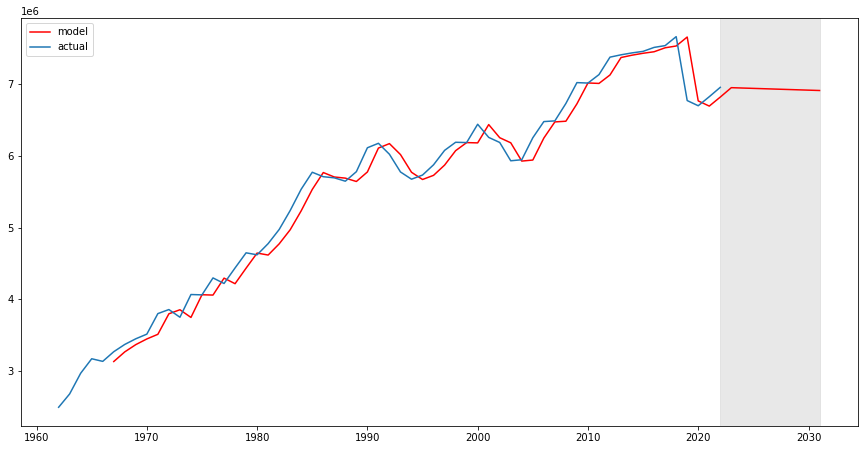

In [87]:
# Plot 
new['arima_model'] = best_model.fittedvalues
new['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=new.shape[0], end=new.shape[0] + 8)
forecast = new['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(new.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(new['y'], label='actual')
plt.legend()
plt.show()

# SARIMA evaluation

In [90]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error

# Generate predictions on test data
y_pred = pd.DataFrame(best_model.predict('1961-12-31'))

# Calculate root mean squared error
mae = mean_absolute_error(new['y'][1:], y_pred.predicted_mean[1:])
print('MAE:', mae)


MAE: 154642.12903513826


In [93]:
# R2_score
from sklearn.metrics import r2_score
r2 = r2_score(new['y'][1:], y_pred.predicted_mean[1:])
print(r2)

0.9774621310341118


# Saving Model

In [123]:
import pickle as pkl

In [124]:
pkl.dump(best_model, open('sarima.pkl', 'wb'))

# Model inference

In [147]:
import pickle as pkl
loaded_model = pkl.load(open('sarima.pkl', 'rb'))

print(loaded_model.predict('2023'))

2023-12-31    6.946342e+06
Freq: A-DEC, dtype: float64


In [150]:
loaded_model.predict('2023')[0]

6946341.896362813

###### SARIMA model predicts till next 300 years from the starting year of traiing data i.e. till 2261 as our data has initial year as 1961